In [115]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
consumer_key = "QVxvK4k62JwB6kldgSTHwHKCq"
consumer_secret = "CyviaswXC8nubNMBt4FiLOBx6YaBqfyhClSuTh1IOzfoRJzeOR"
access_key = "69484937-vr5Pmqr8gVuBqPUZx7FfyDut8XIsRTOENgDzHsswU"
access_secret = "Slfi12057fmE8qSilYQURMnNDWK6GVqCceeuDejJKC6yi"

In [4]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []

    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print("getting tweets before %s" % (oldest))

        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        print("...%s tweets downloaded so far" % (len(alltweets)))

    #transform the tweepy tweets into a 2D array that will populate the csv
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]

    return outtweets

In [96]:
from nltk.corpus import stopwords
import re

In [6]:
tweets = get_all_tweets("BasicFit_ESP")

getting tweets before 862584607274917887
...399 tweets downloaded so far
getting tweets before 827446893986926591
...598 tweets downloaded so far
getting tweets before 791195706962870271
...798 tweets downloaded so far
getting tweets before 753881582264516608
...997 tweets downloaded so far
getting tweets before 718023218615959551
...1197 tweets downloaded so far
getting tweets before 687334008238272512
...1397 tweets downloaded so far
getting tweets before 656022901313916927
...1593 tweets downloaded so far
getting tweets before 645875774931795967
...1789 tweets downloaded so far
getting tweets before 632122822555500544
...1982 tweets downloaded so far
getting tweets before 611903608808939520
...2176 tweets downloaded so far
getting tweets before 600936616274825215
...2367 tweets downloaded so far
getting tweets before 581439330696212480
...2565 tweets downloaded so far
getting tweets before 573091793170014207
...2759 tweets downloaded so far
getting tweets before 562174618644258815
.

In [7]:
df = pd.DataFrame(tweets, columns=["id", "timestamp", "tweets"])

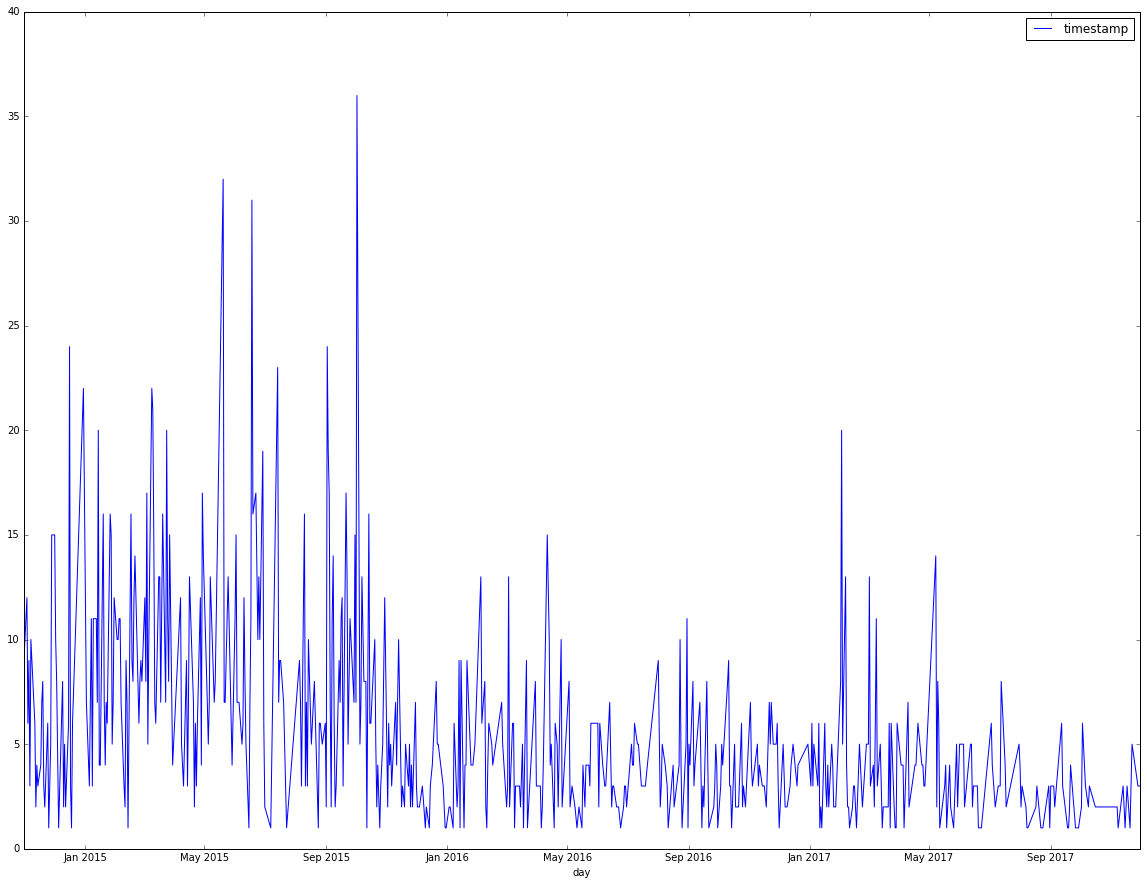

In [8]:
df['timestamp'] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d")
df['day'] = df['timestamp'].apply(lambda x: x.date())
#tips.groupby('sex')['total_bill'].count()
tweets = df.groupby('day').agg({'timestamp': np.size})
tweets.plot(figsize=(20,15))

In [99]:
def clean_tweets(tweet):
    words = []
    for word in tweet.split(" "):
        if word not in stopwords.words('spanish') and 'http' not in word and '@' not in word:
            words.append(re.sub(r'\W+', '', word.lower(), flags=re.LOCALE))
    
    return " ".join(words)

In [100]:
df["tweets"] = df['tweets'].apply(lambda x: clean_tweets(x))

# Convert to NMF cluster

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [103]:
def nmf_generator(series, n=3):

    vectorizer = TfidfVectorizer()
    vectorizer = vectorizer.fit(series)
    texts_vectorized = vectorizer.transform(series).todense()

    feature_words = vectorizer.get_feature_names()

    nmf = NMF(n_components=n,init='random')
    nmf_weights = nmf.fit_transform(texts_vectorized)
    nmf_features = nmf.components_
    return nmf_weights

In [104]:
def text_to_cluster(nmf_weights):
    cluster = []
    number_clusters = len(nmf_weights[0])
    for array in nmf_weights:
        i = np.argmax(array)
        for c in xrange(number_clusters):
            if i == c:
                cluster.append(c)
    return cluster

In [108]:
def generate_text_cluster(series):
    return " ".join(series.tolist())

In [112]:
from wordcloud import WordCloud

In [121]:
def word_cloud(text, i):
    wordcloud = WordCloud(background_color='white').generate(text)
    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud)
    plt.axis("off");
    plt.savefig("../images/cluster_" + str(i))

0
1
2


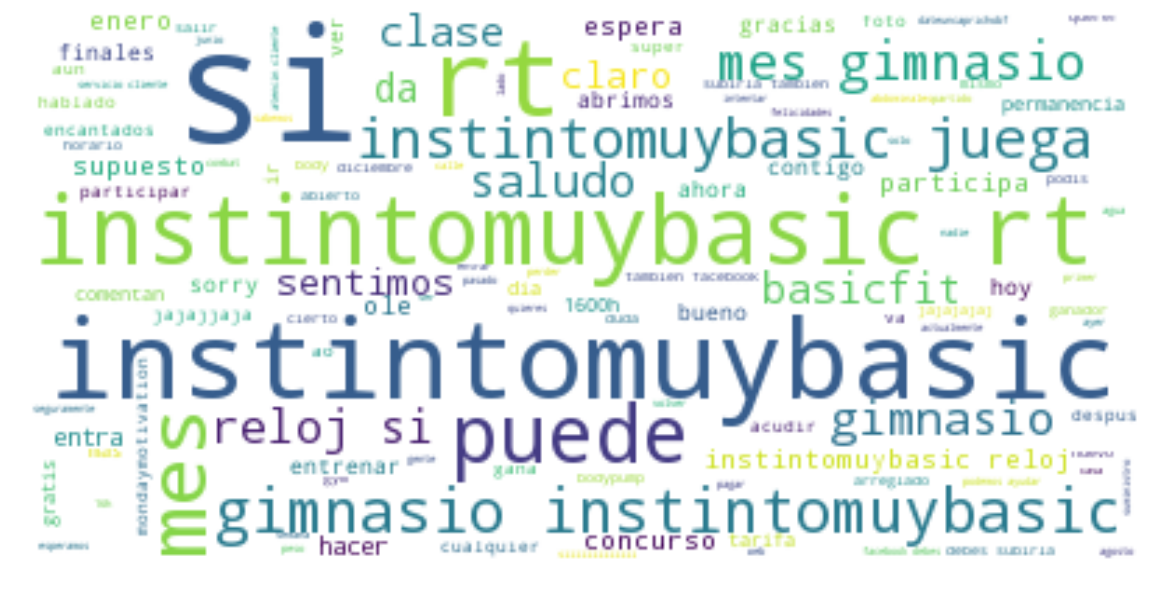

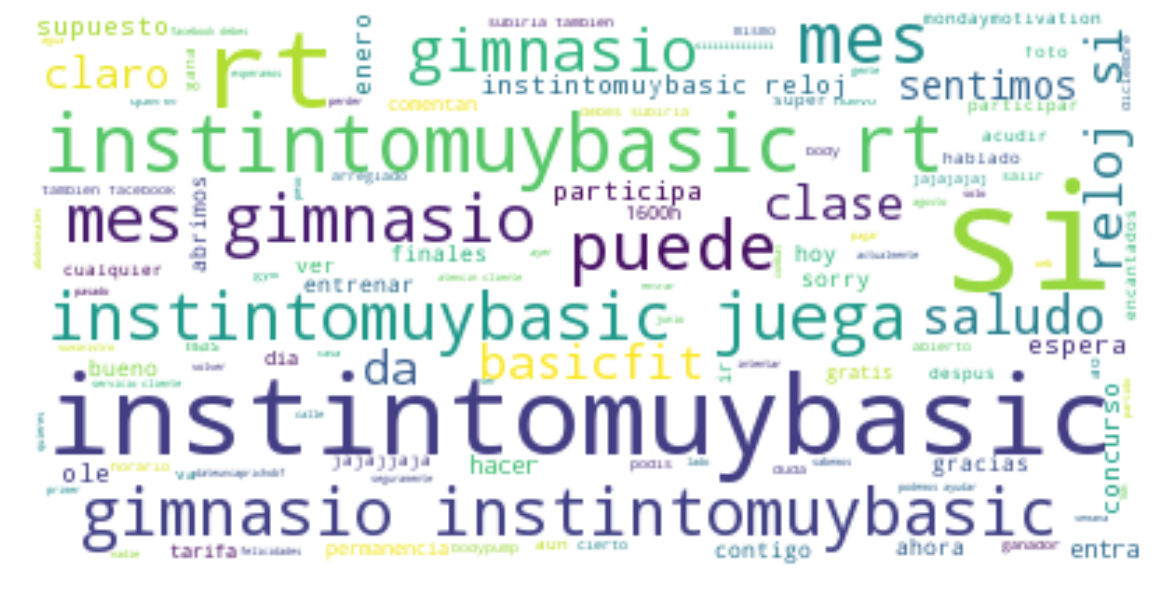

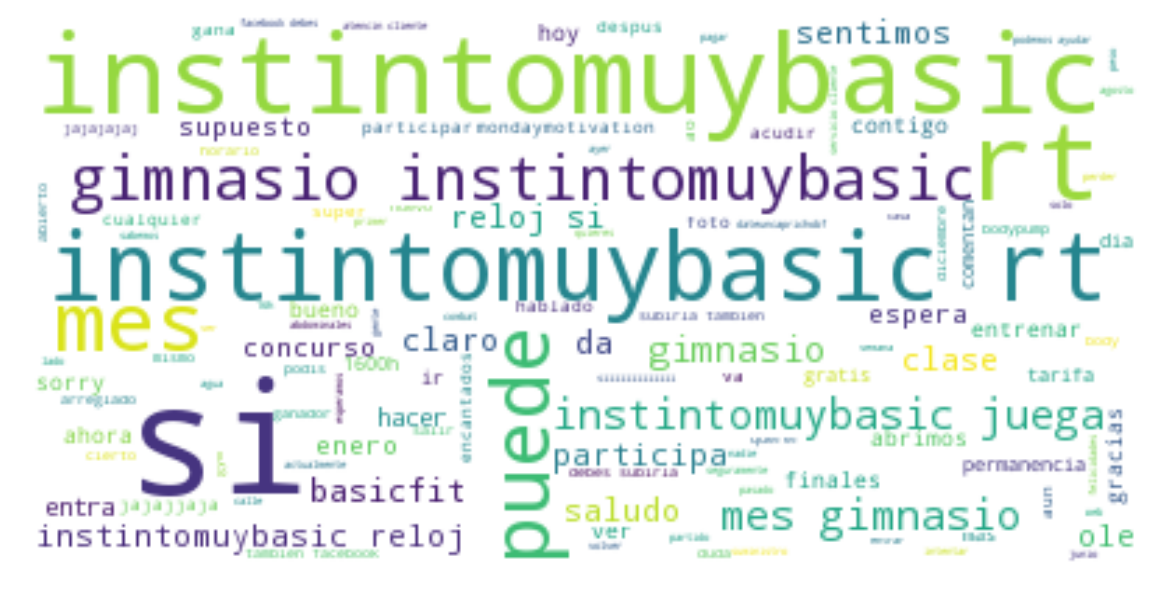

In [122]:
weights = nmf_generator(df["tweets"], 5)
df["cluster"] = text_to_cluster(weights)
n=3


for i in range(n):
    text =  generate_text_cluster(df[df["cluster"] == n]["tweets"])
    word_cloud(text, i)

In [105]:
df.head()

,id,timestamp,tweets,day,cluster
0,936165680663224320,2017-11-30 09:31:06,vamosssssssssssssssssssssss,2017-11-30,3
1,936165645120692224,2017-11-30 09:30:57,dos meses mas,2017-11-30,1
2,936165561305894912,2017-11-30 09:30:37,rt after gym,2017-11-30,1
3,935484062541795328,2017-11-28 12:22:35,,2017-11-28,0
4,935483910364057600,2017-11-28 12:21:59,bien,2017-11-28,1


3169

In [32]:
for i in nmf_features:
    print i[0]

0.013516432144
0.00178540163389
1.31313624808e-05


In [27]:
nmf_weights

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.76008674e-03,   2.96550935e-03,   5.50680777e-05],
       [  1.45837565e-01,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.95260381e-02,   5.24949683e-03,   0.00000000e+00],
       [  1.04112251e-02,   2.54541777e-03,   4.18924592e-03],
       [  1.17779646e-01,   0.00000000e+00,   0.00000000e+00]])

In [ ]:
 #Generate Word Clouds from a text being inputed.

wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis("off");

In [146]:
import tweepy
import pandas as pd
from nltk.corpus import stopwords

#Twitter API credentials
CONSUMER_KEY = "QVxvK4k62JwB6kldgSTHwHKCq"
CONSUMER_SECRET = "CyviaswXC8nubNMBt4FiLOBx6YaBqfyhClSuTh1IOzfoRJzeOR"
ACCESS_KEY = "69484937-vr5Pmqr8gVuBqPUZx7FfyDut8XIsRTOENgDzHsswU"
ACCESS_SECRET = "Slfi12057fmE8qSilYQURMnNDWK6GVqCceeuDejJKC6yi"

def clean_tweets(tweet):
    words = []
    for word in tweet.split(" "):
        if word not in stopwords.words('spanish') and 'http' not in word and '@' not in word:
            words.append(word.lower())
    
    return " ".join(words)


def get_all_tweets(screen_name):
    #Limited to 3240 tweets with this method
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth)
    
    alltweets = []
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1
    print("getting tweets") 
    while len(new_tweets) > 0:
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        alltweets.extend(new_tweets)
        oldest = alltweets[-1].id - 1
 
    print("Tweets Extracted")
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text] for tweet in alltweets]
    return outtweets

In [147]:
tweets = (get_all_tweets("iberia"))

getting tweets
Tweets Extracted


In [148]:
df = pd.DataFrame(tweets, columns=["id", 'time_stamp', 'tweets'])
df["tweets"] = df["tweets"].apply(clean_tweets)